In [2]:
%%js
function add(x, y)
{
    var z=x+y;
    alert("x+y="+z.toString());
}   
add(10,14)

<IPython.core.display.Javascript object>

In [1]:
# enable python linting
%load_ext nb_black

# input dataset
input_file = "../data/all_combined_training.csv"
validation_file = "../data/all_combined_validation.csv"

dfName = None
processed_data = lambda dfName: "../data/" + dfName + "_processed.csv"

model_root = "../artifacts/models/"
data_root = "../data/"
fig_root = "../figs/"
package_root = "../packages/"
root = "../"

<IPython.core.display.Javascript object>

In [2]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
from scipy.stats import probplot
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80

import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, ForecastingGridSearchCV)
from sklearn.linear_model import LinearRegression

from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load
from IPython.core.pylabtools import figsize
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

In [3]:
dfName = "df2"

<IPython.core.display.Javascript object>

In [4]:
# load data
df = pd.read_csv(processed_data(dfName), index_col=0)
df.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
9945,2014,2,19,9,1000.29325,62.20071,-75.65,1483,1347.844242,-33.116232,2014-02-19 00:00:00,0.674507,2014-02-19 09:00:00
19379,2015,3,19,11,1097.35025,62.20071,-75.65,1483,1347.844242,-27.666327,2015-03-19 00:00:00,0.739953,2015-03-19 11:00:00


<IPython.core.display.Javascript object>

## Split the dataframe by locationa and sort by datetime

In [5]:
df.head()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,849.450417,62.20071,-75.65,1483,1347.844242,-19.559714,2013-01-01 00:00:00,0.572792,2013-01-01 00:00:00
1,2013,1,1,1,891.025667,62.20071,-75.65,1483,1347.844242,-19.994040,2013-01-01 00:00:00,0.600826,2013-01-01 01:00:00
2,2013,1,1,2,905.738833,62.20071,-75.65,1483,1347.844242,-19.779135,2013-01-01 00:00:00,0.610748,2013-01-01 02:00:00
3,2013,1,1,3,847.466417,62.20071,-75.65,1483,1347.844242,-18.466940,2013-01-01 00:00:00,0.571454,2013-01-01 03:00:00
4,2013,1,1,4,823.321083,62.20071,-75.65,1483,1347.844242,-18.182593,2013-01-01 00:00:00,0.555173,2013-01-01 04:00:00


<IPython.core.display.Javascript object>

## Hourly resolution

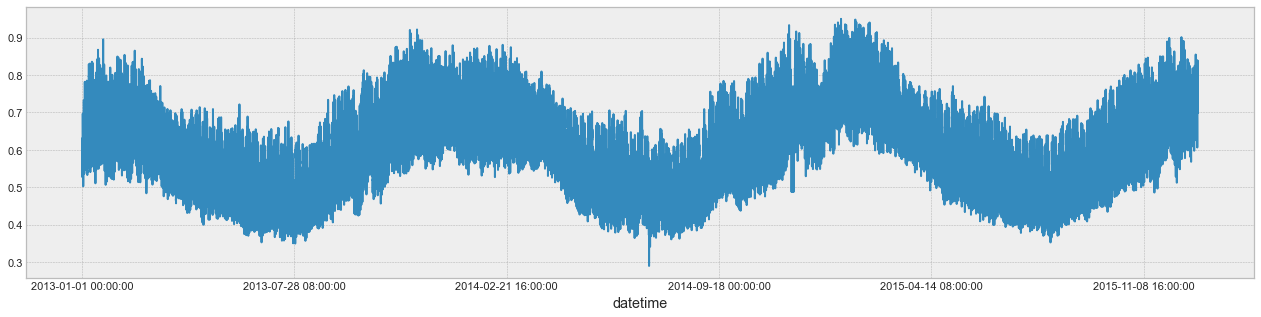

<IPython.core.display.Javascript object>

In [6]:
data = df.set_index("datetime")
data = data["kw_cap"]
data.plot(figsize=(22, 5))
plt.show()

In [7]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test

    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(
        "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
    )
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

<IPython.core.display.Javascript object>

In [8]:
# tsplot(df2.kw_cap, lags=24*7*52)

<IPython.core.display.Javascript object>

## Split the data

In [9]:
s = df.kw_cap
print(len(s))

26280


<IPython.core.display.Javascript object>

In [10]:
test_len = 365 * 24
s_train, s_test = temporal_train_test_split(s, test_size=test_len)
test_len

8760

<IPython.core.display.Javascript object>

In [11]:
# we have NO missing data
len(s) - 365 * 3 * 24

0

<IPython.core.display.Javascript object>

## Define plot_forecast() function

In [12]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None, extra_title="", train_label="train", test_label="test", 
                  figsize=(12, 4)):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)
    rmse = sqrt(mean_squared_error(series_test, forecast))

    plt.figure(figsize=figsize)
    plt.title(extra_title + f"MAE: {mae:.2f}, MAPE: {mape:.3f}, RMSE: {rmse:.3f}", size=18)
    series_train.plot(label=train_label, color="b")
    series_test.plot(label=test_label, color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape, rmse


<IPython.core.display.Javascript object>

## Define moving average

In [13]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast."""
    mov = np.cumsum(series)
    # the past $window_size number of data points, the series has to be a Numpy array,
    # which is quite different from Pandas Series
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1 : -1] / window_size

<IPython.core.display.Javascript object>

In [14]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

<IPython.core.display.Javascript object>

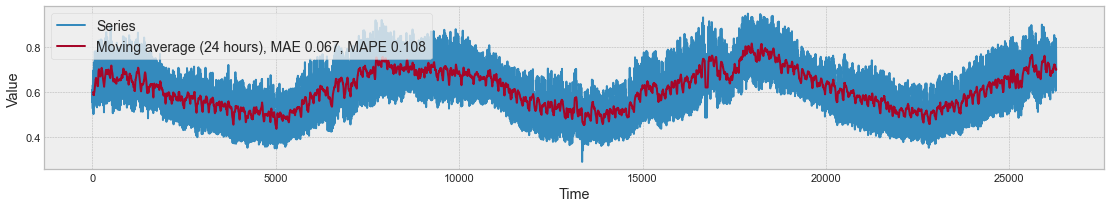

<IPython.core.display.Javascript object>

In [15]:
# moving average is calculated as the past window_size number of hours' average
window_size = 24 * 1
moving_avg = moving_average_forecast(np.array(s), window_size)

mape = mean_absolute_percentage_error(moving_avg[-len(s_test) :], s_test)
mae = mean_absolute_error(moving_avg[-len(s_test) :], s_test)

plt.figure(figsize=(19, 3))
plot_series(range(len(s)), s, label="Series")
plot_series(
    range(window_size, len(s)),
    moving_avg,
    label=f"Moving average ({window_size} hours), MAE {mae:.3f}, MAPE {mape:.3f}",
)

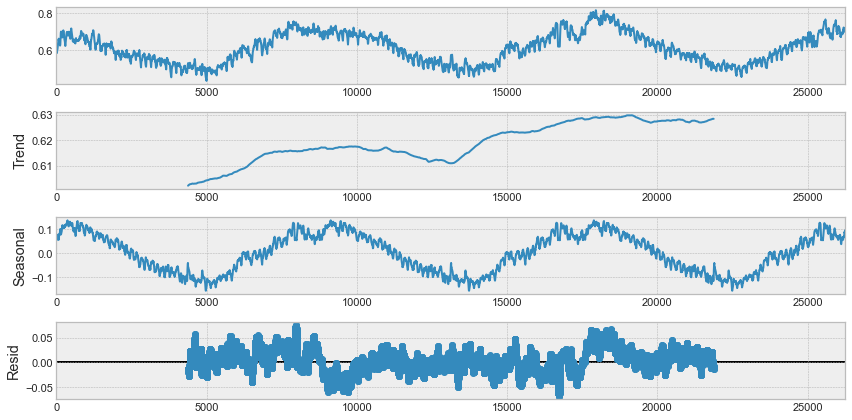

<IPython.core.display.Javascript object>

In [16]:
moving_avg = pd.Series(moving_avg)
decomp = seasonal_decompose(moving_avg, model="additive", period=365 * 24)
plt.rcParams.update({"figure.figsize": (12, 6)})
_ = decomp.plot().suptitle("")

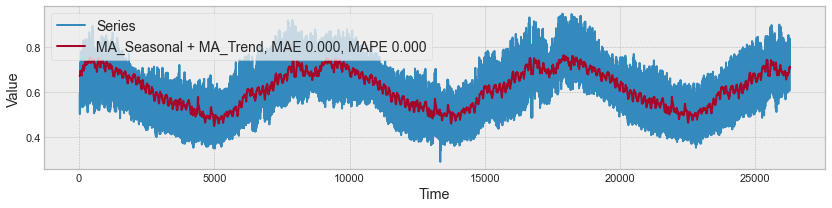

<IPython.core.display.Javascript object>

In [17]:
s_sesonal_n_trend = decomp.seasonal + decomp.trend.fillna(decomp.trend.mean())

mape = mean_absolute_percentage_error(s[-len(s_test) :], s_test)
mae = mean_absolute_error(s[-len(s_test) :], s_test)

plt.figure(figsize=(14, 3))
plot_series(
    range(len(s) - len(s_sesonal_n_trend), len(s)), s[window_size:], label="Series"
)
plot_series(
    range(len(s) - len(s_sesonal_n_trend), len(s)),
    s_sesonal_n_trend,
    label=f"MA_Seasonal + MA_Trend, MAE {mae:.3f}, MAPE {mape:.3f}",
)

## Forecast with `lgbregressor()`
- make_reduction(), During fitting, a sliding-window approach is used to first transform the time series into tabular or panel data, which is then used to fit a tabular or time-series regression estimator. During prediction, the last available data is used as input to the fitted regression estimator to generate forecasts. This is the process where we transform a time series into the `(X,y)` form, where `(X,y)` is a single input data point, not the entire set `(X_1, y_1).....(X_n, y_n)`. 
    - `window_length` in `make_reduction()` is  `len(X_i)`.
- `forecaster` is different from `regressor`. In forecasting, past data is used to make temporal forward predictions of a time series. This is notably different from tabular prediction tasks supported by scikit-learn and similar libraries.
- In fit, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data. In predict, the composite algorithm presents the regressor with the last observed window to obtain predictions.

Check more [here](https://www.sktime.org/en/stable/examples/01_forecasting.html#3.-Advanced-composition-patterns---pipelines,-reduction,-autoML,-and-more)


In [18]:
def create_forecaster_w_desesonalizer(
    regressor,
    model="additive",
    sp=365 * 5,
    degree=1,
    window_length=10 * 24,
    strategy="recursive",
    scitype="infer",
):

    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model=model, sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(
                    regressor,
                    window_length=window_length,
                    strategy=strategy,
                    scitype=scitype,
                ),
            ),
        ]
    )

    return forecaster

<IPython.core.display.Javascript object>

In [19]:
def regular_forecaster(
    train, test, forecaster, model_path=None, train_label="train", test_label="test"
):

    forecaster.fit(train)

    if model_path:
        dump(forecaster, model_path)

    # forecasting, note the len(fh) must satisfy some requirements, here we have len(fh)= len(test)
    fh = np.arange(len(test)) + 1
    y_pred = forecaster.predict(fh=fh)
    mae, mape, rmse = plot_forecast(
        train,
        test,
        y_pred,
        train_label=train_label,
        test_label=test_label,
        figsize=(14, 4),
    )

    return mae, mape, rmse

<IPython.core.display.Javascript object>

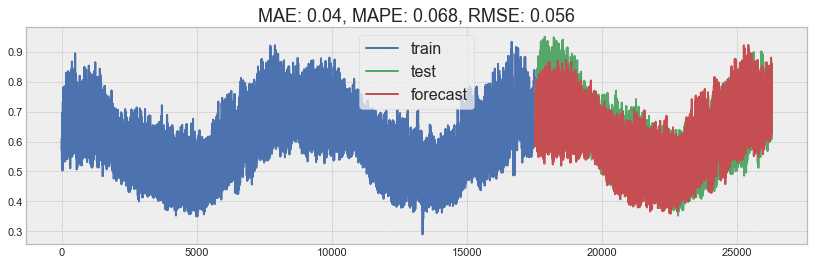

<IPython.core.display.Javascript object>

In [20]:
regressor = lgb.LGBMRegressor(n_estimators=30, learning_rate=0.05)
# it's important to have the rigth seasonal_period sp=365*24
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365 * 24)

s_lgb_mae, s_lgb_mape, s_lgb_rmse = regular_forecaster(
    s_train, s_test, forecaster, model_path=model_root + "lgbm_forecaster.pickle"
)

__Total RMSE using LGB__

In [21]:
print(s_lgb_rmse * df.population[1])

82.84191026049925


<IPython.core.display.Javascript object>

__Predict a whole year ahead__

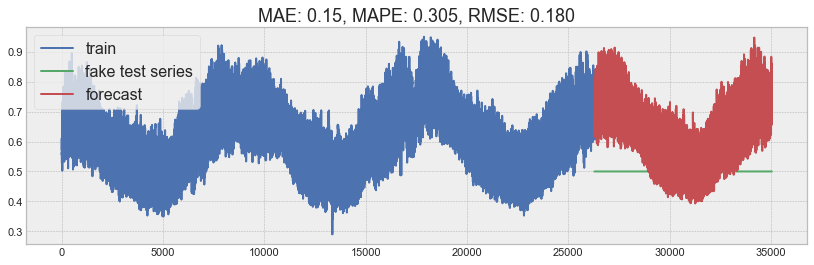

<IPython.core.display.Javascript object>

In [22]:
regressor = lgb.LGBMRegressor(n_estimators=30, learning_rate=0.05)
# it's important to have the rigth seasonal_period sp=365*24
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365 * 24)

fake_test_series = pd.Series(0.5, index=range(len(s), len(s) + 365 * 24))
s_lgb_mae, s_lgb_mape, s_lgb_rmse = regular_forecaster(
    s,
    fake_test_series,
    forecaster,
    model_path=model_root + "lgbm_forecaster.pickle",
    test_label="fake test series",
)

__Moving average seems to perform slightly worse__
* note that we need to `pd.concat()` (NOT add) another series of length `24x7` to `ma`, in order to have a `ma_train` of the correct length, otherwise `regular_forecaster()` won't work. 

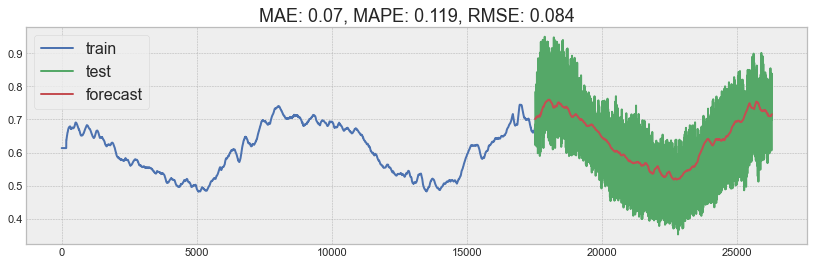

<IPython.core.display.Javascript object>

In [23]:
window_size = 24 * 7
# ma is shorter than s_train because the first window takes out 168 data points, for regular_forecaster() work, we have to fill the 168 with something
ma = moving_average_forecast(np.array(s), window_size)
ma = pd.Series(ma, index=range(window_size, len(s)))
# ma_train should be very close to s_train, it has to satisfy this relation:
# (ma_train - s_train[window_size:]).sum()<<ma_train.sum()
ma_train = pd.concat([pd.Series(ma.mean(), index=range(window_size)), ma])

regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365 * 24)

_, _, _ = regular_forecaster(ma_train, s_test, forecaster, model_path=None)

## `Linear` forecaster:

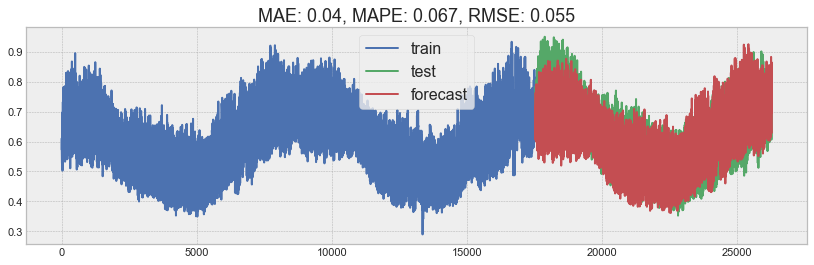

<IPython.core.display.Javascript object>

In [24]:
regressor = LinearRegression()  # linearRegressor has scitype='tabular-regressor'

forecaster = create_forecaster_w_desesonalizer(
    regressor, sp=365 * 24, scitype="tabular-regressor"
)

s_lgb_mae, s_lgb_mape, s_lgb_rmse = regular_forecaster(
    pd.Series(s_train), pd.Series(s_test), forecaster, model_path=None
)

__Total RMSE using LinearForcaster__

In [25]:
lnr_rmse = s_lgb_rmse * df.population[1]
print("RMSE is: " + str(lnr_rmse))
print("population is: " + str(df.population[1]))

RMSE is: 82.08027228783182
population is: 1483


<IPython.core.display.Javascript object>

__Predicting a whole year ahead__

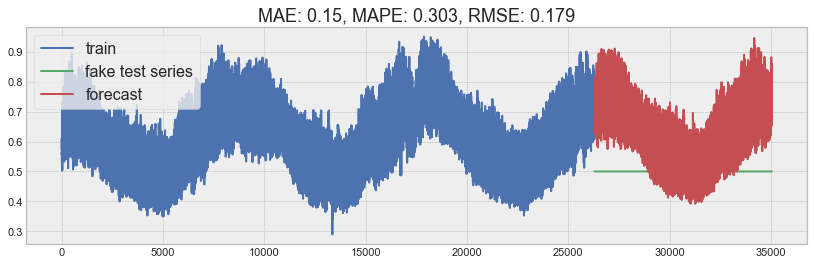

<IPython.core.display.Javascript object>

In [26]:
regressor = LinearRegression()
# it's important to have the rigth seasonal_period sp=365*24
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365 * 24)

fake_test_series = pd.Series(0.5, index=range(len(s), len(s) + 365 * 24))
s_lgb_mae, s_lgb_mape, s_lgb_rmse = regular_forecaster(
    s,
    fake_test_series,
    forecaster,
    model_path=model_root + "lgbm_forecaster.pickle",
    test_label="fake test series",
)

__Moving average seems to perform slightly worse__

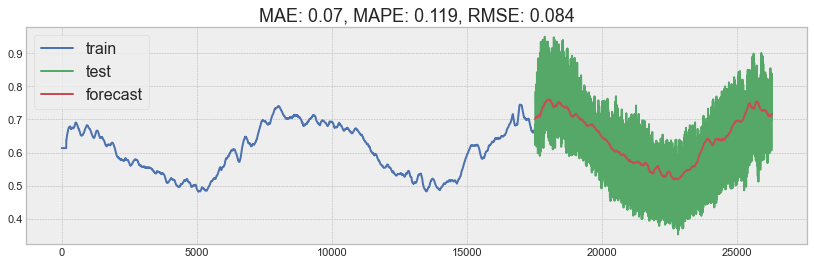

<IPython.core.display.Javascript object>

In [27]:
window_size = 24 * 7
ma = moving_average_forecast(np.array(s), window_size)
ma = pd.Series(ma, index=range(window_size, len(s)))
# ma_train should be very close to s1_train, it has to satisfy this relation:
# (ma_train - s1_train[window_size:]).sum()<<ma_train.sum()
ma_train = pd.concat([pd.Series(ma.mean(), index=range(window_size)), ma])

regressor = LinearRegression()  # linearRegressor has scitype='tabular-regressor'
forecaster = create_forecaster_w_desesonalizer(
    regressor, sp=365 * 24, scitype="tabular-regressor"
)

_, _, _ = regular_forecaster(ma_train, s_test, forecaster, model_path=None)